In [1]:
import numpy as np 
import pandas as pd 
import  matplotlib.pyplot as plt
# import tensorflow as tf
# import keras
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
# import pickle
# import xgboost as xgb
from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score , accuracy_score , confusion_matrix , f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
train_df  =  pd.read_csv('/content/drive/MyDrive/cs419m/train.csv')
test_df  =  pd.read_csv('/content/drive/MyDrive/cs419m/test.csv')
test_labels_df =  pd.read_csv('/content/drive/MyDrive/cs419m/test_labels.csv')

In [3]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
test_labels_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
print(test_df.shape)
print(train_df.shape)

(153164, 2)
(159571, 8)


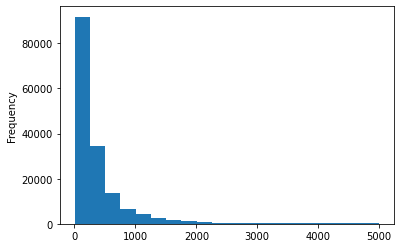

In [9]:
train_df['comment_text'].apply(len).plot(bins=20,kind='hist')

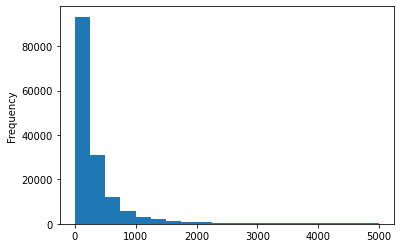

In [10]:
test_df['comment_text'].apply(len).plot(bins=20,kind='hist')

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [12]:
test_df.describe()

,id,comment_text
count,153164,153164
unique,153164,153164
top,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
freq,1,1


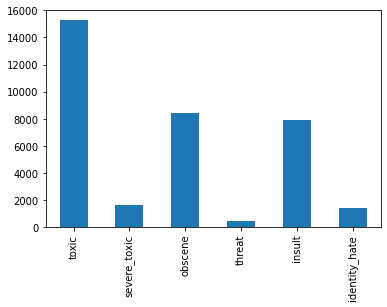

In [13]:
train_df.drop(['id','comment_text'],axis=1).apply(sum).plot(kind='bar')

In [14]:
nltk.download('stopwords')
nltk.download('word_tokenize')
nltk.download('punkt')
eng_stopwords = set(stopwords.words('english'))
word_stemmer = SnowballStemmer(language='english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading word_tokenize: Package 'word_tokenize' not
[nltk_data]     found in index
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
def  preprocess_text(text):
    text =  text.lower() # lower the text
    # substitute few short hand
    text = re.sub(r"\r", "", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)

    text = re.sub('<.*?>','',text).strip() # remove html chars
    text = re.sub('\[|\(.*\]|\)','', text).strip() # remove text in square brackets and parenthesis

    # text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation marks
    text = re.sub("(\\W)"," ",text) # remove non-ascii chars
    text = re.sub('\S*\d\S*\s*','', text) # remove words containing numbers
    text = text.strip()

    words = word_tokenize(text)
    words = [word_stemmer.stem(w) for w in words if not w in eng_stopwords]
    text = " ".join(words)
    return text

In [16]:
train_df['comment_text'] = train_df['comment_text'].apply(preprocess_text)

In [17]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww match background colour seem stuck thank ...,0,0,0,0,0,0
2,000113f07ec002fd,hey man realli tri edit war guy constant remov...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggest improv wonder section statis...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chanc rememb page,0,0,0,0,0,0


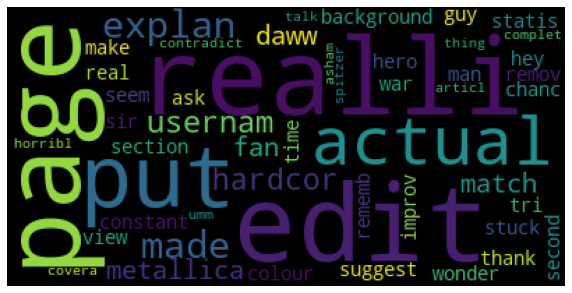

In [18]:
wordcloud = WordCloud(stopwords=stopwords.words('english'),max_words=50).generate(str(train_df['comment_text']))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [19]:
x =  train_df['comment_text'].values
y =  train_df.drop(['id','comment_text'],axis = 1).values

In [44]:
x_train,x_val,y_train,y_val =  train_test_split(x,y,test_size = 0.2,random_state = 45)

In [45]:
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',     
    analyzer='word',            
    token_pattern=r'\w{1,}',    
    ngram_range=(1, 3),         
    stop_words='english',
    sublinear_tf=True)

word_vectorizer.fit(x_train)    
train_word_features = word_vectorizer.transform(x_train)

In [46]:
X_train_transformed = word_vectorizer.transform(x_train)
X_val_transformed = word_vectorizer.transform(x_val)

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
# from sklearn.svm import SVC
model_to_set = OneVsRestClassifier(LogisticRegression(random_state=45))
# parameter grid
parameters = {
    "estimator__C": [1,10,100],
    "estimator__penalty": ['l1','l2'],
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters,cv=ShuffleSplit(test_size=0.2,n_splits=1,random_state=0),verbose=3,
                             scoring='roc_auc')

model_tunning.fit(X_train_transformed, y_train)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1] END estimator__C=1, estimator__penalty=l1;, score=nan total time=   0.2s
[CV 1/1] END estimator__C=1, estimator__penalty=l2;, score=0.974 total time= 6.1min
[CV 1/1] END estimator__C=10, estimator__penalty=l1;, score=nan total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 1/1] END estimator__C=10, estimator__penalty=l2;, score=0.977 total time= 9.9min
[CV 1/1] END estimator__C=100, estimator__penalty=l1;, score=nan total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 1/1] END estimator__C=100, estimator__penalty=l2;, score=0.975 total time=10.5min


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 6.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py", line 347, in fit
    for i, column in enumerate(columns)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/parall

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=0, test_size=0.2, train_size=None),
             estimator=OneVsRestClassifier(estimator=LogisticRegression(random_state=45)),
             param_grid={'estimator__C': [1, 10, 100],
                         'estimator__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=3)

In [28]:
print(model_tunning.best_score_)
print(model_tunning.best_params_)

0.9769671486346817
{'estimator__C': 10, 'estimator__penalty': 'l2'}


In [60]:
log_reg = LogisticRegression(C=10,penalty='l2',max_iter=1000,random_state=45)

classifier_log = OneVsRestClassifier(log_reg)
classifier_log.fit(X_train_transformed, y_train)


y_train_pred_proba = classifier_log.predict_proba(X_train_transformed)
y_val_pred_proba = classifier_log.predict_proba(X_val_transformed)


roc_auc_score_train = roc_auc_score(y_train, y_train_pred_proba,average='weighted')
roc_auc_score_val = roc_auc_score(y_val, y_val_pred_proba,average='weighted')

print("ROC AUC Score Train:", roc_auc_score_train)
print("ROC AUC Score Val:", roc_auc_score_val)

ROC AUC Score Train: 0.9998060214877398
ROC AUC Score Val: 0.9776632104233016


In [50]:
from sklearn.naive_bayes import MultinomialNB
log_reg = MultinomialNB()

classifier = OneVsRestClassifier(log_reg)
classifier.fit(X_train_transformed, y_train)


y_train_pred_proba = classifier.predict_proba(X_train_transformed)
y_val_pred_proba = classifier.predict_proba(X_val_transformed)


roc_auc_score_train = roc_auc_score(y_train, y_train_pred_proba,average='weighted')
roc_auc_score_val = roc_auc_score(y_val, y_val_pred_proba,average='weighted')

print("ROC AUC Score Train:", roc_auc_score_train)
print("ROC AUC Score Val:", roc_auc_score_val)

ROC AUC Score Train: 0.9478140881681701
ROC AUC Score Val: 0.8395751357391595


In [51]:
def make_test_predictions(df,classifier):
    df['comment_text'] = df['comment_text'].apply(preprocess_text)
    X_test = df['comment_text'].values
    X_test_transformed = word_vectorizer.transform(X_test)
    y_test_pred = classifier.predict_proba(X_test_transformed)
    return y_test_pred

In [52]:
test_labels_df.shape

(153164, 7)

In [53]:
test_df.shape

(153164, 2)

In [54]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate']

In [55]:
test_labels_df[test_labels_df[label_cols].sum(axis=1)!=(-6)]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,0,0,0,0,0,0
153151,fff9d70fe0722906,0,0,0,0,0,0
153154,fffa8a11c4378854,0,0,0,0,0,0
153155,fffac2a094c8e0e2,1,0,1,0,1,0


In [56]:
test_df[test_labels_df[label_cols].sum(axis=1)!=(-6)]

,id,comment_text
5,0001ea8717f6de06,thank understand think high would revert witho...
7,000247e83dcc1211,dear god site horribl
11,0002f87b16116a7f,somebodi invari tri add religion realli mean w...
13,0003e1cccfd5a40a,say right type type institut need case three l...
14,00059ace3e3e9a53,ad new product list make sure relev ad new pro...
...,...,...
153150,fff8f64043129fa2,jerom see never got around surpris look exampl...
153151,fff9d70fe0722906,lucki bastard httpwikimediafoundationorgwikipr...
153154,fffa8a11c4378854,shame want speak gay romanian
153155,fffac2a094c8e0e2,mel gibson nazi bitch make shitti movi much bu...


In [61]:
test_pred_probability = make_test_predictions(test_df[test_labels_df[label_cols].sum(axis=1)!=(-6)],classifier_log)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
test_pred_probability.shape

(63978, 6)

In [63]:
roc_auc_score_test = roc_auc_score(test_labels_df[test_labels_df[label_cols].sum(axis=1)!=(-6)][label_cols].values, test_pred_probability,average='weighted')
print("ROC AUC Score Test:", roc_auc_score_test)

ROC AUC Score Test: 0.9674944657935176
